In [2]:
import pandas as pd
import numpy as np

In [4]:
# Load in the data

raw = pd.read_csv('../data/external/final_pphdatabase_merge_topost2.tab', sep='\t')

In [5]:
keep_cols = ['study', 'txtarm', 'pphloss', 'activebldcontrol', 'overallbld', 'age', 'iv_fluids', 'par_cat', 'q6_1', 'q7_1', 'q8_1', 'q9_1', 'q10_1', 'q11_1', 'q13_1','q14_1', 'q17_1', 'q8_2', 'q9_2', 'q10_2', 'pphloss', 'q14_2']

In [6]:
raw['q14_2'].value_counts()

1    1337
2     424
3      26
Name: q14_2, dtype: int64

In [7]:
#need to transform q13_1 from weeks.days to days

df = raw[keep_cols].copy()
df['gestation_age'] = df['q13_1'].astype(str).str.split('.', expand=True)[0].astype(float) * 7 + df['q13_1'].astype(str).str.split('.', expand=True)[1].astype(float)
df.drop(columns=['q13_1'], inplace=True)

In [8]:
df[df['study'] == 2].to_csv('../data/processed/goodvars.csv', index=False)

Post Julia work

In [30]:
combined_test = pd.read_csv("../data/processed/test.csv")
combined_train = pd.read_csv("../data/processed/train.csv")

In [32]:
combined_test

,pphloss,age,iv_fluids,par_cat,q6_1,q7_1,q8_1,q9_1,q10_1,q14_1,q17_1,q8_2,q9_2,q10_2,pphloss_1,q14_2,gestation_age,txtarm,activebldcontrol
0,700,21,1,1,3.0,1,0.0,0.0,3.0,0,9.5,0,0,0,700,1,273.0,1,1
1,700,22,1,1,3.0,1,0.0,0.0,3.0,0,9.7,0,0,0,700,1,252.0,2,1
2,700,26,1,1,3.0,1,0.0,0.0,1.0,0,11.6,1,1,0,700,1,273.0,1,1
3,700,23,1,1,2.0,1,0.0,0.0,2.0,0,10.3,0,0,0,700,1,266.0,2,1
4,700,32,1,3,2.0,1,3.0,3.0,1.0,0,13.8,1,1,0,700,1,280.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,650,21,1,1,3.0,1,0.0,0.0,2.0,0,9.6,1,1,0,650,2,271.0,2,0
397,900,19,1,1,2.0,1,0.0,0.0,1.0,0,10.3,1,1,1,900,1,280.0,1,1
398,950,22,1,2,1.0,1,1.0,1.0,1.0,0,12.4,1,1,1,950,1,273.0,2,1
399,750,22,1,1,2.0,1,0.0,0.0,1.0,0,11.6,1,1,1,750,1,273.0,1,1


In [411]:
train_X = combined_train.drop(columns=['activebldcontrol', 'txtarm'], axis=1)
train_treatments = combined_train['txtarm']
train_y = combined_train['activebldcontrol']

test_X = combined_test.drop(columns=['activebldcontrol', 'txtarm'], axis=1)
test_treatments = combined_test['txtarm']
test_y = combined_test['activebldcontrol']

In [475]:
from econml.policy import DRPolicyForest, DRPolicyTree
from sklearn.linear_model import LogisticRegressionCV

policy_tree = DRPolicyTree(model_regression=RandomForestClassifier(max_depth=4), max_depth=4, random_state=42, min_samples_leaf=10, categories=[1, 2], honest=False)

policy_tree.fit(train_y, train_treatments, X=train_X)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [476]:
policy_tree.policy_treatment_names()

['None', 'txtarm_2']

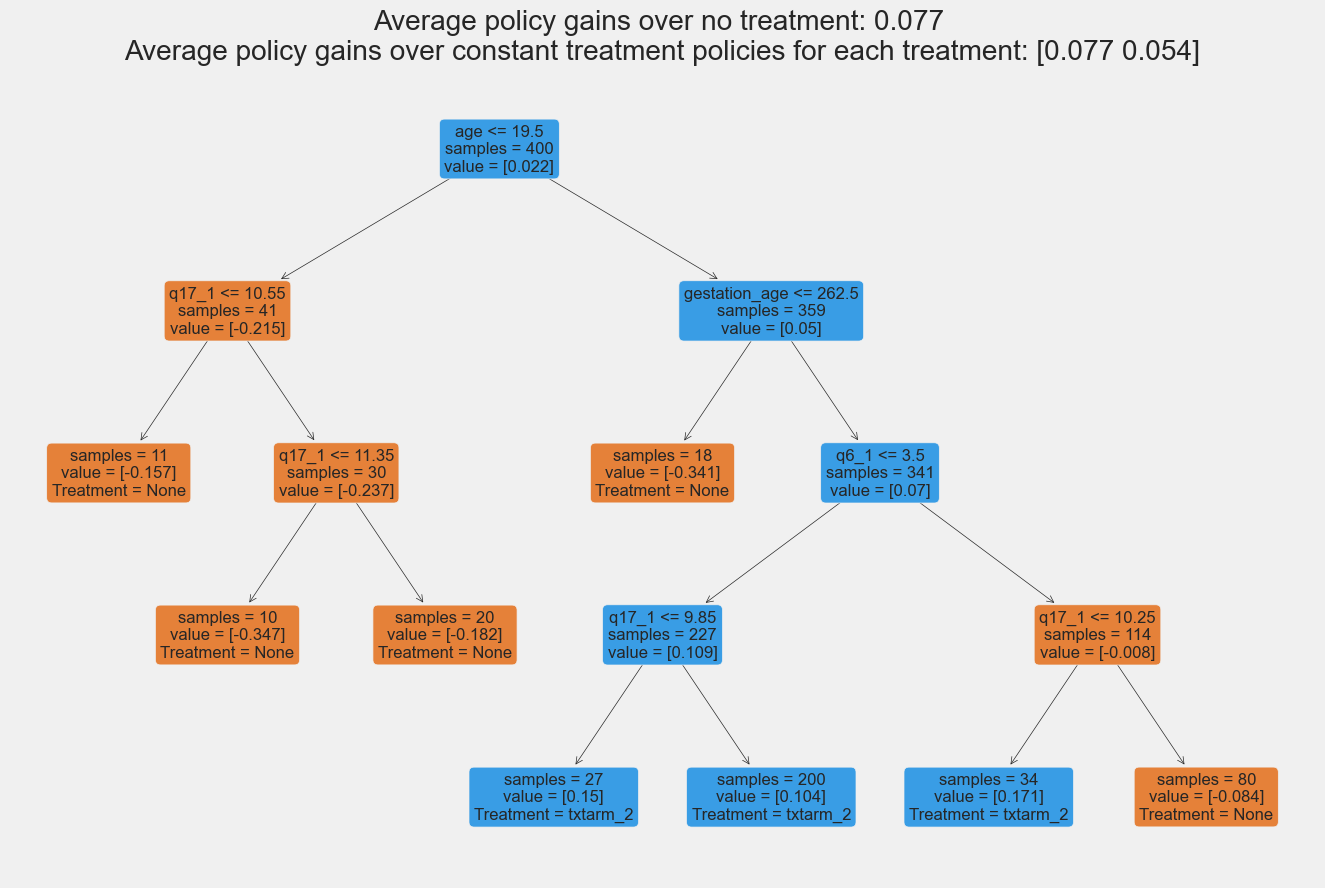

In [479]:
plt.figure(figsize=(15, 10))
policy_tree.plot(ax=plt.gca(), fontsize=12, feature_names=train_X.columns)
plt.savefig('../reports/figures/policy_tree_forest.png')

In [480]:
combined_test[policy_tree.predict(test_X)==0].shape

(129, 19)

In [478]:
(combined_test[policy_tree.predict(test_X)==0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[policy_tree.predict(test_X)==0].shape[0]/400)\
+ (combined_test[policy_tree.predict(test_X)==1].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[policy_tree.predict(test_X)==1].shape[0]/400)

0.8791558441558442

In [481]:
policy_tree = DRPolicyTree(model_regression=XGBClassifier(max_depth=4), max_depth=4, random_state=42, categories=[1, 2], honest=False, min_samples_leaf=10)

policy_tree.fit(train_y, train_treatments, X=train_X)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

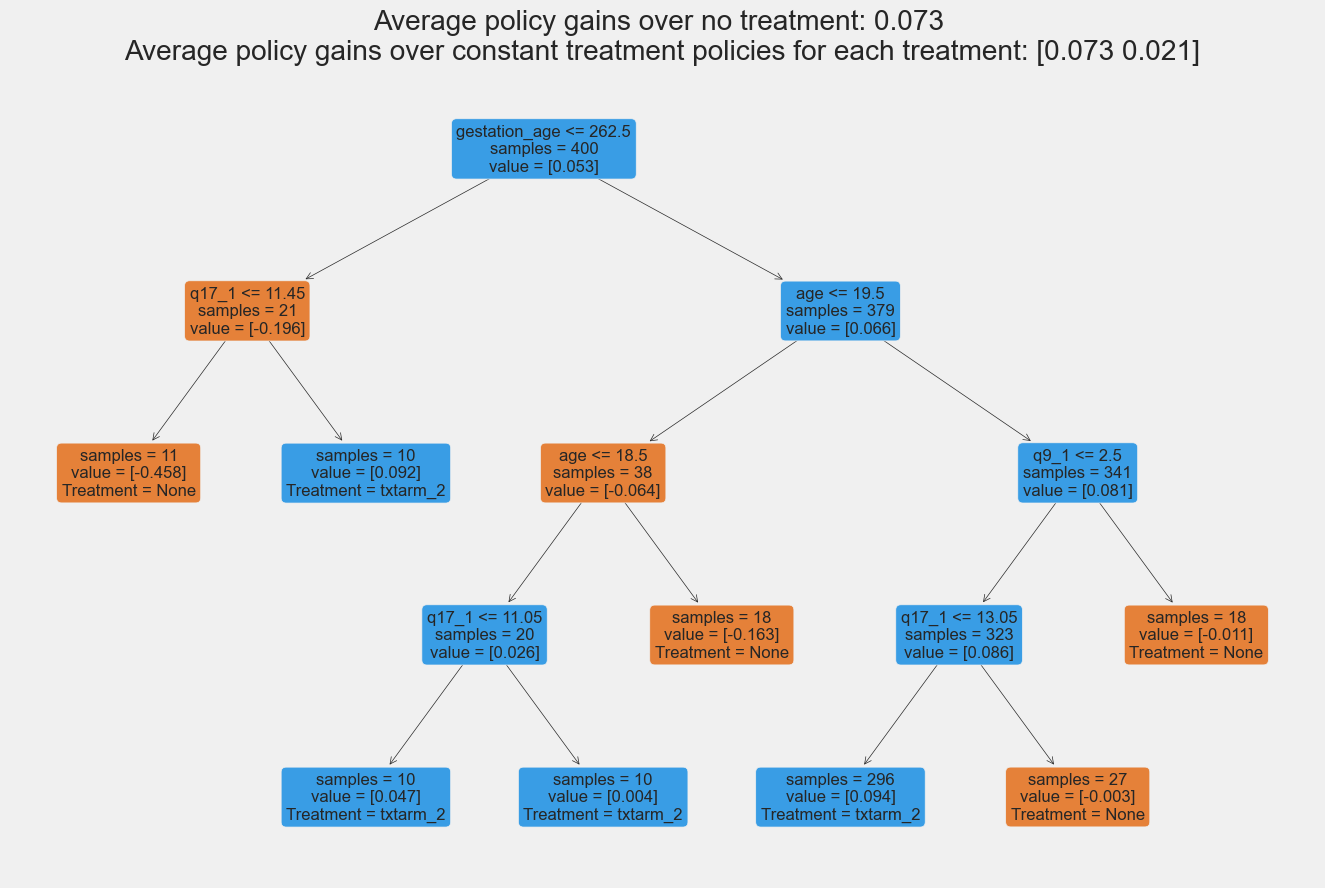

In [482]:
plt.figure(figsize=(15, 10))
policy_tree.plot(ax=plt.gca(), fontsize=12, feature_names=train_X.columns)
plt.savefig('../reports/figures/policy_tree_xgb.png')

In [483]:
(combined_test[policy_tree.predict(test_X)==0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[policy_tree.predict(test_X)==0].shape[0]/400)\
+ (combined_test[policy_tree.predict(test_X)==1].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[policy_tree.predict(test_X)==1].shape[0]/400)

0.8744313417190777

In [485]:
combined_test[policy_tree.predict(test_X)==1].shape

(308, 19)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

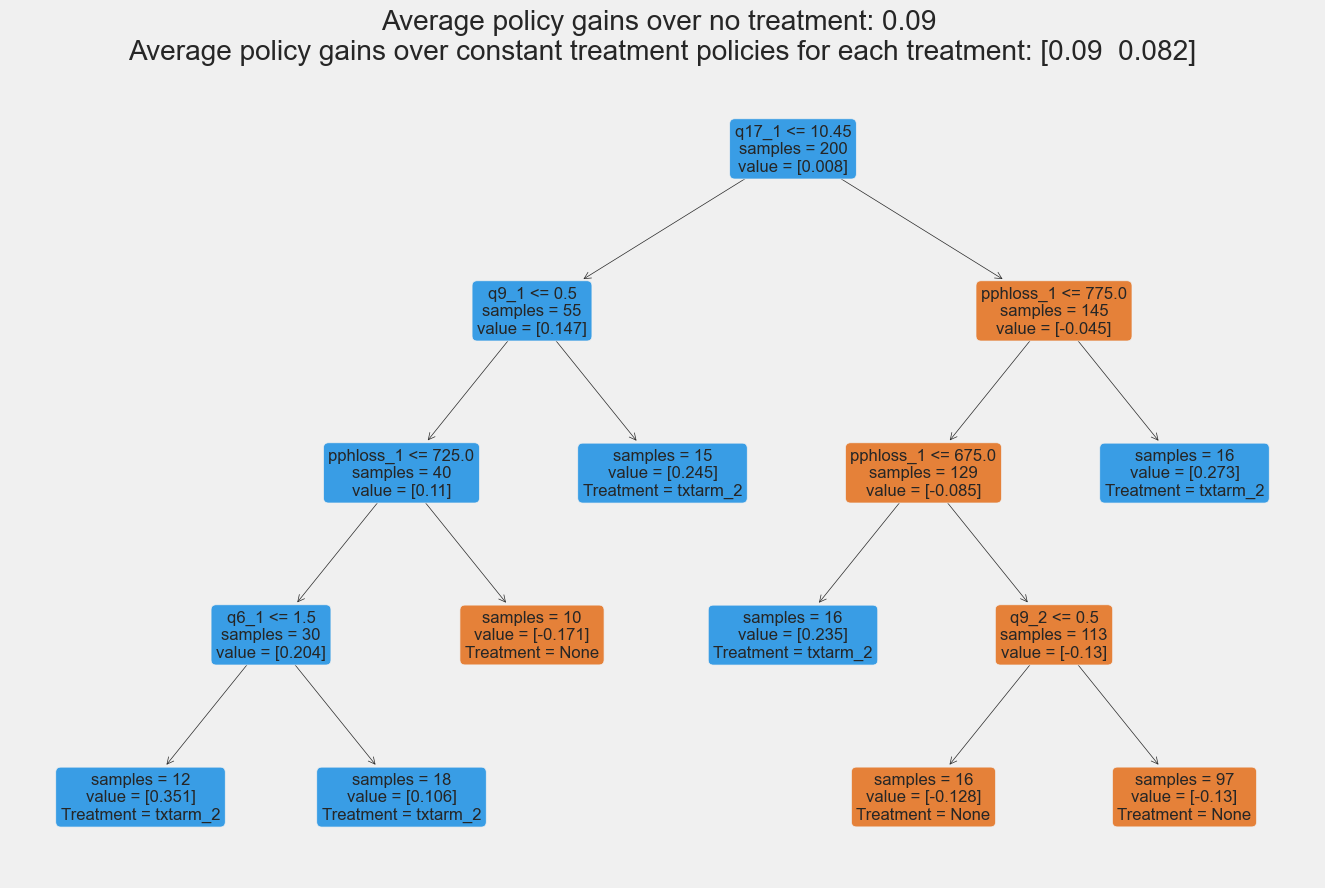

In [495]:
forest = DRPolicyForest(model_regression=RandomForestClassifier(max_depth=4), max_depth=4, random_state=42, categories=[1, 2], honest=False, min_samples_leaf=10, n_estimators=1000)

forest.fit(train_y, train_treatments, X=train_X)

plt.figure(figsize=(15, 10))
forest.plot(ax=plt.gca(), fontsize=12, feature_names=train_X.columns, tree_id=0)
plt.savefig('../reports/figures/policy_forest_rf.png')

In [496]:
combined_test[forest.predict(test_X)==0].shape

(170, 19)

In [497]:
(combined_test[forest.predict(test_X)==0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[forest.predict(test_X)==0].shape[0]/400)\
+ (combined_test[forest.predict(test_X)==1].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[forest.predict(test_X)==1].shape[0]/400)

0.8990214913708889

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

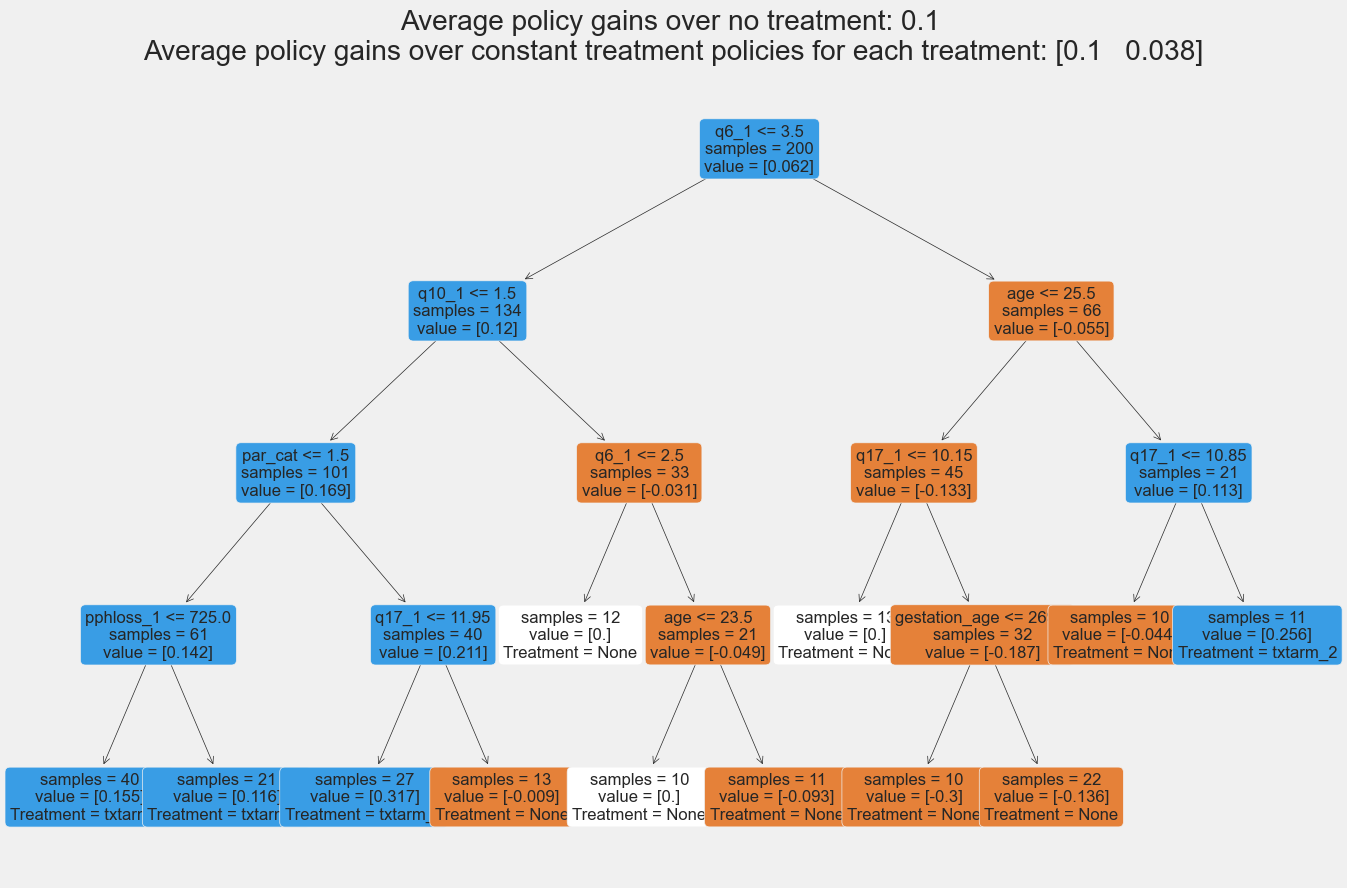

In [488]:
forest = DRPolicyForest(model_regression=XGBClassifier(max_depth=4), max_depth=4, random_state=42, categories=[1, 2], honest=False, min_samples_leaf=10, n_estimators=1000)

forest.fit(train_y, train_treatments, X=train_X)

plt.figure(figsize=(15, 10))
forest.plot(ax=plt.gca(), fontsize=12, feature_names=train_X.columns, tree_id=0)
plt.savefig('../reports/figures/policy_forest_xgb.png')

In [493]:
combined_test[forest.predict(test_X)==0].shape

(120, 19)

In [489]:
(combined_test[forest.predict(test_X)==0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[forest.predict(test_X)==0].shape[0]/400)\
+ (combined_test[forest.predict(test_X)==1].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[forest.predict(test_X)==1].shape[0]/400)

0.9119365491213587

In [498]:
from econml.dml import SparseLinearDML
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

est = SparseLinearDML(model_y=XGBClassifier(max_depth=7), model_t=XGBClassifier(max_depth=7), discrete_treatment=True, max_iter=4000, random_state=42)
est.fit(train_y, train_treatments, X=train_X, W=None)

In [499]:
est.score(test_y,  test_treatments, X=test_X, W=None)

0.10804705270657804

In [500]:
t1_test = np.ones((test_X.shape[0], 1))
t2_test = np.ones((test_X.shape[0], 1))*2

In [501]:
sum(est.effect(test_X, T0=t1_test, T1=t2_test) < 0)

381

In [502]:
(combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)>=0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)>=0].shape[0]/400)\
+ (combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)<=0].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)<=0].shape[0]/400)

0.8801087394281112

In [503]:
from econml.dml import CausalForestDML

est = CausalForestDML(model_y=XGBClassifier(max_depth=5), model_t=XGBClassifier(max_depth=5), discrete_treatment=True, random_state=42)
est.fit(train_y, train_treatments, X=train_X, W=None)


In [504]:
est.score(train_y, train_treatments, X=train_X, W=None)

0.0339991089434991

In [505]:
sum(est.effect(test_X, T0=t1_test, T1=t2_test) < 0)

64

In [469]:
(combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)>=0].groupby('txtarm')['activebldcontrol'].mean()[1]*combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)>=0].shape[0]/400)\
+ (combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)<=0].groupby('txtarm')['activebldcontrol'].mean()[2]*combined_test[est.effect(test_X, T0=t1_test, T1=t2_test)<=0].shape[0]/400)

0.891665551093262

In [470]:
graphdata = pd.DataFrame({"Reward Estimator": ["-", "-", "-", "RF/DR", "XGB/DR", "RF/DR", "XGB/DR", "RF/DR", "XGB/DR", "XGB/SparseLinearDML", "XGB/CausalForest"],
"Policy Assignment": ["Oracle RCT", "Blanket RCT", "Optimal Prescription Tree", "Optimal Policy Tree", "Optimal Policy Tree", "Policy Tree", "Policy Tree", "Policy Forest", "Policy Forest", "Regress & Compare", "Regress & Compare"],
"Policy Effect": [0.9064, 0.8838, 0.8929, 0.8942, 0.8971, 0.8774, 0.8884, 0.8944, 0.9119, 0.8801, 0.8916]
})

In [471]:
import seaborn as sns

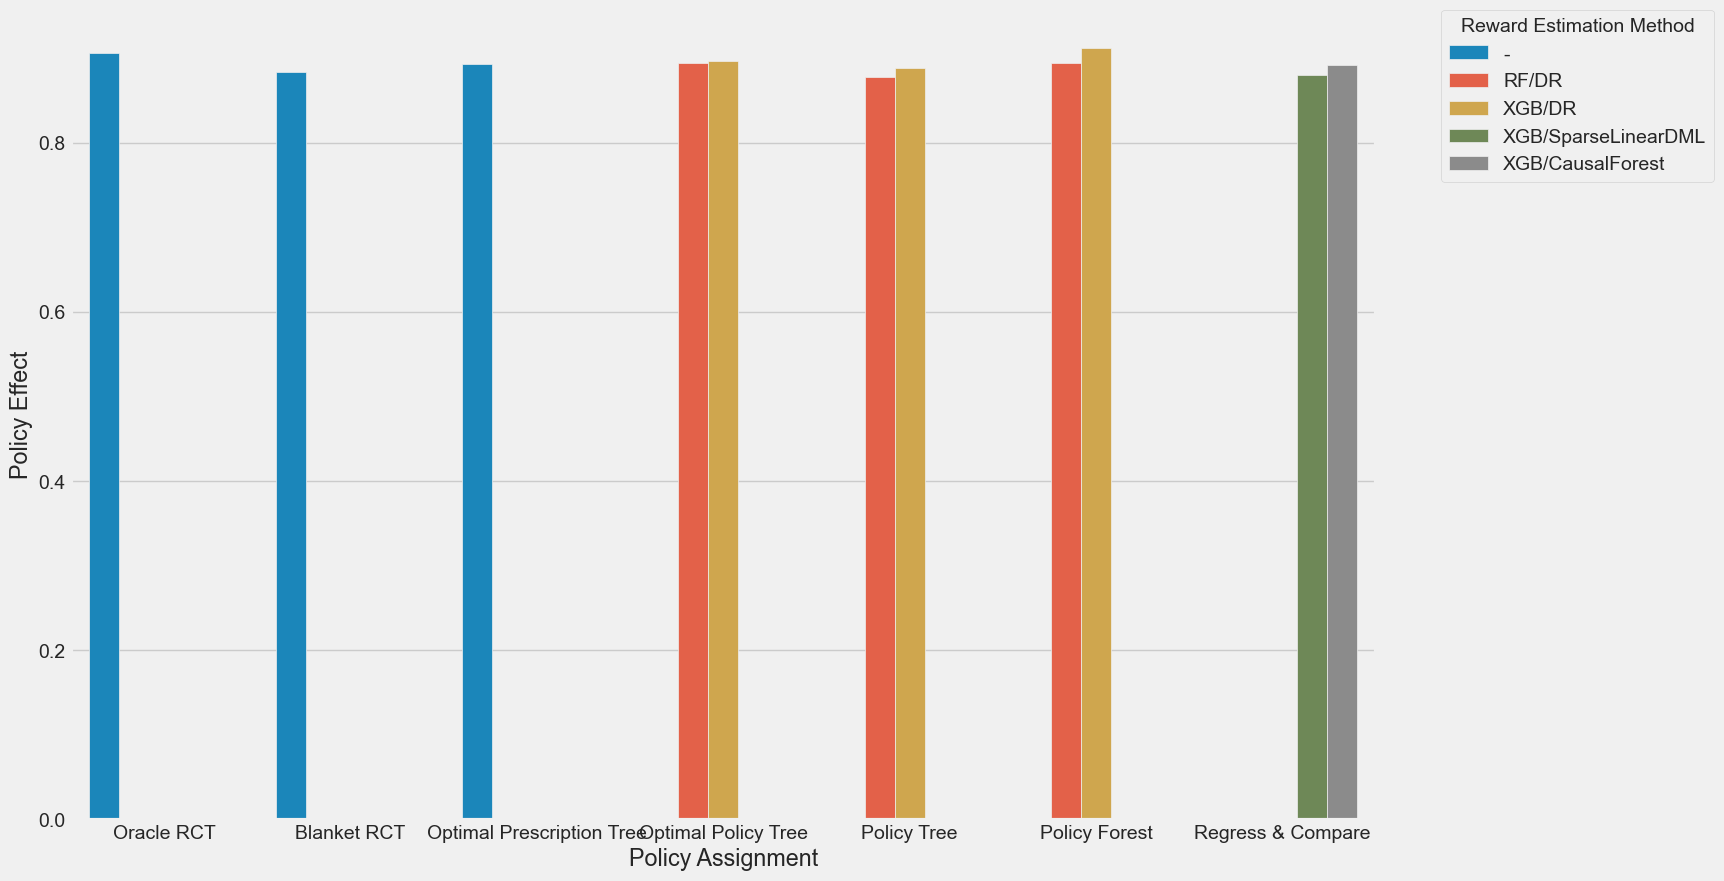

In [472]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.style.use('fivethirtyeight')

sns.barplot(x="Policy Assignment", y="Policy Effect", hue="Reward Estimator", data=graphdata, ax=ax)

#move legend to upper right outside of plot

plt.legend(title="Reward Estimation Method", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [473]:
graphdata['Expected Patients with Uncontrolled Bleeding'] = (1 - graphdata['Policy Effect'])*401

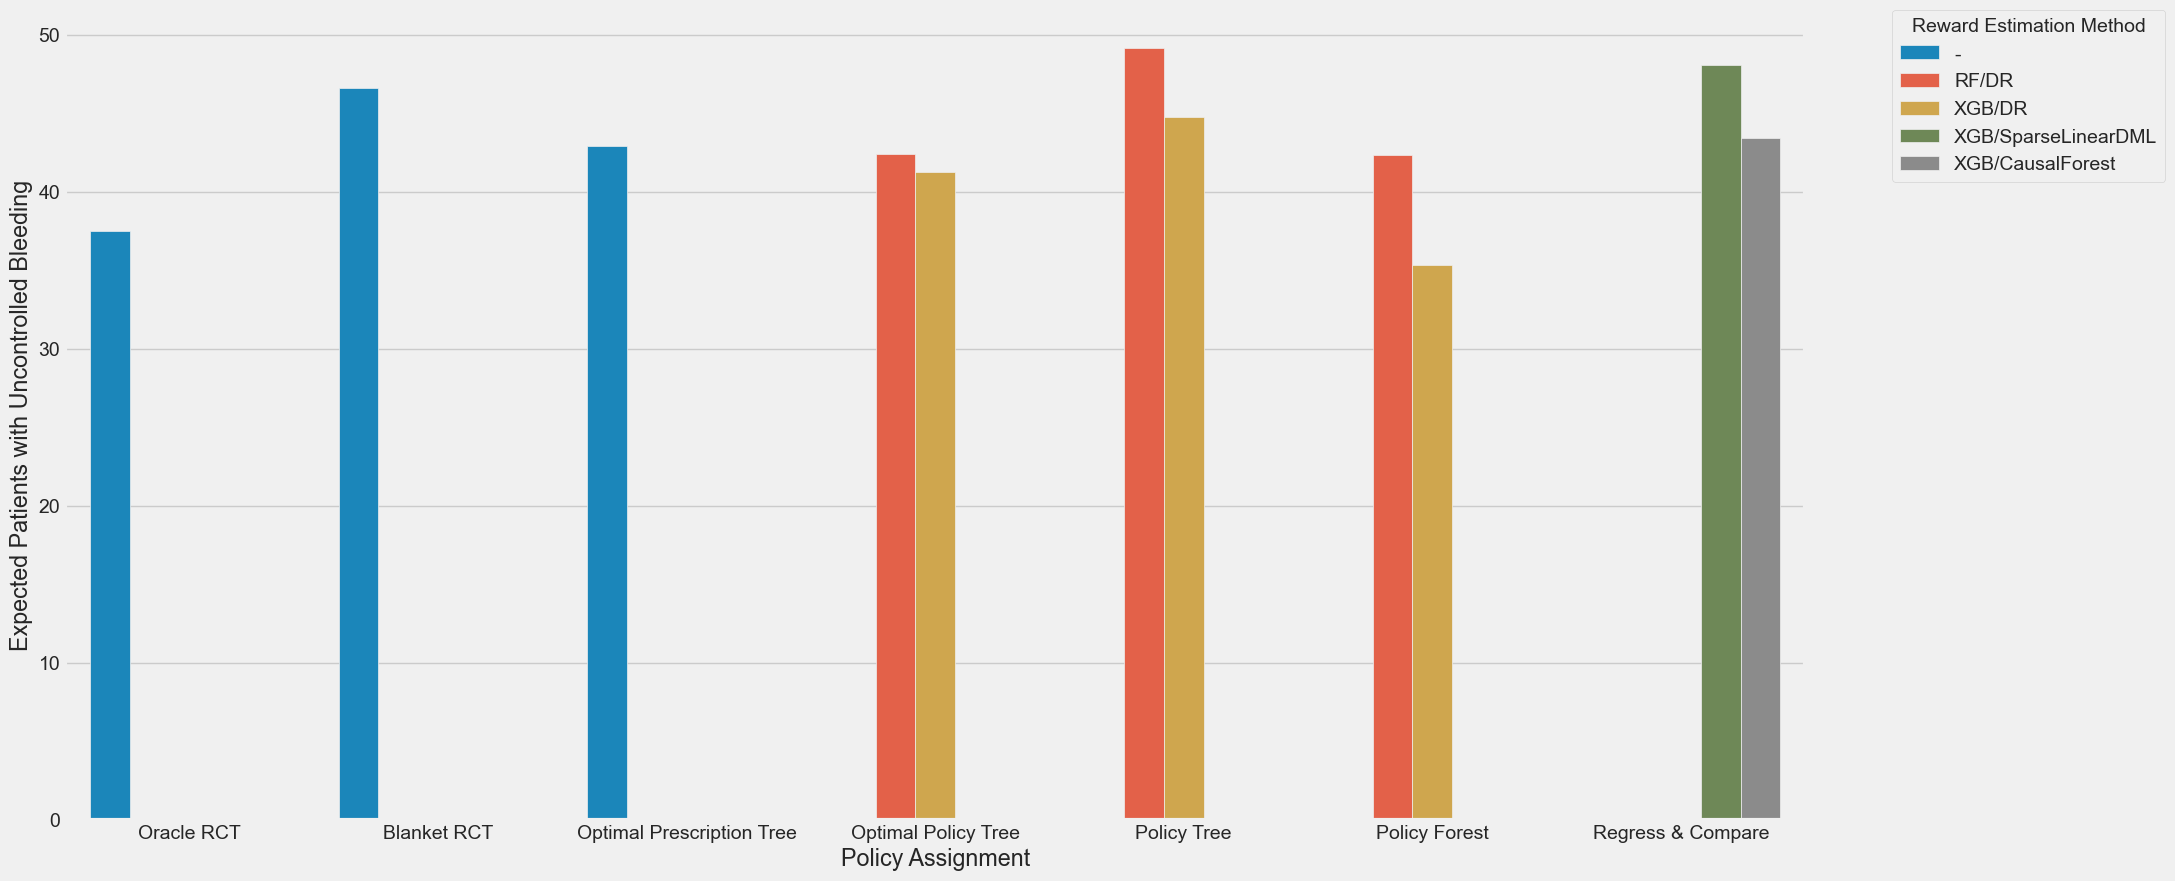

In [474]:
#plot the expected number of patients with uncontrolled bleeding

fig, ax = plt.subplots(figsize=(20, 10))

plt.style.use('fivethirtyeight')

sns.barplot(x="Policy Assignment", y="Expected Patients with Uncontrolled Bleeding", hue="Reward Estimator", data=graphdata, ax=ax)

#move legend to upper right outside of plot

plt.legend(title="Reward Estimation Method", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

